# Simple image classification
## Author: Hörmet Yiltiz
## Date: Oct. 29, 2021


## Executive summary
- Problem description  
  Develop a classification model given input images for training and testing, containing 3000 images in total, that amount to about 1 billion data points.
  
- Simple solution  
  A custom model performs as good as the best model with only two clearly interpretable parameters.
  
- More sophisticated solutions  
  We can use any one of a set of commonly used supervised machine learning algorithms for classification.
  
- Lessons learned  
  1. Exploring the data manifold can provide powerful insights, that can be transformed into computational models.
  2. Exclude no extreme values; extreme values tell a different kind of story. Still interesting!
  3. Optimizing algorithms can save your time!

# Qualitative analysis

Steps:

0. Load the data into an appropriate intermediate data structure;
1. Inspect the data with exploratory analysis;
2. Gain some insights into the problem;
3. Propose a set of models.

In [48]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits import mplot3d
from imghdr import what

import numpy as np
import pandas as pd
import seaborn as sns
from plotnine import * # let's take full advantage of the grammar of plots
# from dfply import *  # we could also take advantage of the grammer of data wrangling
import statsmodels as sm
from scipy import optimize
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA # Linear Discriminant
from sklearn.decomposition import PCA

# SVM
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


# using PyTorch for deep nnets
#import torch
#import torch.nn as nn
#import torch.nn.functional as F
#import torch.optim as optim
#from torch.optim.lr_scheduler import StepLR
#from torchvision.io import read_image
#from torchvision import transforms #, datasets

import os
import shutil
import itertools
import json  # to serialize intermediate model state and results

# Metadata saved to output plots
METADATA = {
    "Author": "Hörmet Yiltiz",
    "License": "CC-BY-NC-ND 4.0",
    "Copyright": "Hörmet Yiltiz <hyiltiz@gmail.com>, 2021"
}

# Show plots inline
%matplotlib inline


## Load the data into an appropriate intermediate data structure

The shape of the intermediate data structure:
```
[ 
     { -- One list element per image file
          type: file type
          name: file name
            im: 3D image (in RGB)
      },
      ...
]
```

In [2]:
# Read Images
def load_img(impath :str = './squares/train/a/'):
    """
Reads all images inside a folder and returns them in a list of dictionary
The returned data has the following structure:
   [ 
     { -- One list element per image file
          type: file type
          name: file name
            im: 3D image (in RGB)
      }
   ]
    """
    files = os.listdir(impath)
    
    result = []
    for ximg in files:
        fname = f'{impath}{ximg}'
        if what(fname): # exclude any non-image files if they exist
            cell = dict()
            cell['type'] = what(fname)
            cell['im'] = mpimg.imread(fname)
            cell['name'] = fname
            result.append(cell)
        
    return result


# this is the basic idea for the function above    
img = mpimg.imread('./squares/train/a/0.jpg')
classes = ['a', 'b', 'c']

train = dict()
for label in classes:
    train[label] = load_img(impath = f'./squares/train/{label}/')

# the test set for model evaluation and validation
# test = dict()
# for label in classes:
#     test[label] = load_img(impath = f'./squares/val/{label}/')

# or using dict comprehension for a more concise code
test = {label: load_img(impath = f'./squares/val/{label}/') for label in classes}

## Inspect the data with exploratory analysis

Let's take a quick look at the data by simply showing a random sample for each class.

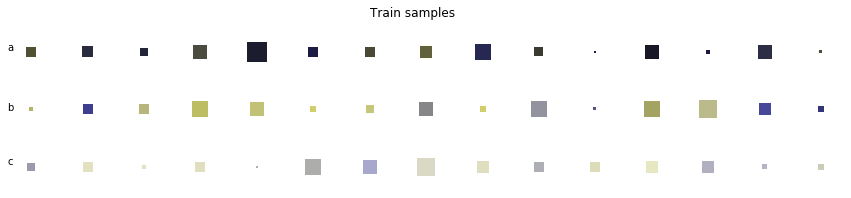

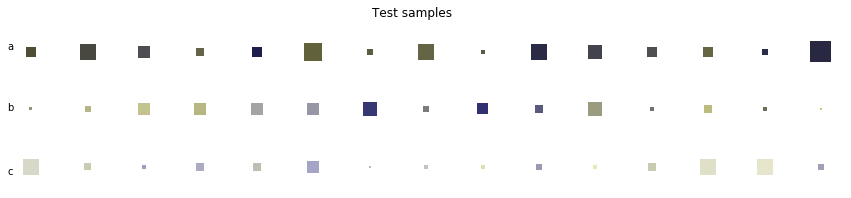

In [3]:
### let's take a quick look at the data
n_sample = 5


def plot_raw(data: dict, n_sample: int = 15, classes: list = classes):
    """
    Creates a simple gallery plot based on a random sample
    """
    cols, rows = n_sample, len(classes)
    figure = plt.figure(figsize=(cols, rows))
    for i, (icol, irow) in enumerate(itertools.product(range(rows), range(cols))):
        ilabel = classes[icol]
        
        sample_idx = np.random.randint(len(data[ilabel]))
        img = data[ilabel][sample_idx]['im']
        figure.add_subplot(rows, cols, i+1)
        # plt.title(ilabel)
        if irow == 0:
            plt.text(0, 220, ilabel,
                 horizontalalignment='left',
                 verticalalignment='center')

        plt.axis("off")
        plt.imshow(img)
    
    return figure


figure = plot_raw(train)
figure.suptitle('Train samples')
plt.show(figure)

figure = plot_raw(test)
figure.suptitle('Test samples')
plt.show(figure)

### Observations

Each row shows samples for a class. We have three classes: `a`, `b` and `c`.

- File types (bmp, jpeg, png)
- All squares (of image and color patch)
- Uniform colored patches:
- Class interpretations:  
  `a`) dark luminance  
  `c`) high luminance (pastel)  
  `b`) mid luminance (saturated colors)  

### Dimensionality reduction (pixel space -> feature space)

Each pixel contains 3 data (RGB triplets) and each image contains 10,000s of pixels. We can see most of the pixels are refundant.

Non-redundant information:
- File type
- File name
- Image dimensions
- Colored square size
- Color
- Class label
- Number of unique colors in each image

In [4]:
ximg = train['a'][3]['im']

def stats_rgb(img):
    """
    return the unique rgb triplets present in an image
    """
    rgb = ximg.reshape(ximg.size//3, 3)
    # plt.imshow(ximg)
    # print(ximg.shape)


    full_set = np.unique(rgb, axis=0)
    white = np.array([1.,1.,1.])
    if all(full_set[-1, ] == white): # if last element is white
        colors = full_set[0:-1]      # then do not include it
        
    return colors


def stats_rgb_fast(img):
    """
    Simply take the RGB from the central pixel. Upon 
    initial analysis, we can confirm that all color
    patches are uniform, thus no need to actually
    reshape, and find the unique RGB triplets.
    """
    # just return the central RGB triplet
    return img[img.shape[0]//2, img.shape[1]//2, :]


def stats_size(img):
    """
    return the length of a side of the colored square
    
    """
    gray = img.sum(axis=2)
    midrow = gray[gray.shape[0]//2, :]
    side = np.count_nonzero(midrow - gray[0]) # ignoring whites
    
    return side


def stats_size_fast(img):
    """
    Only use the midrow and do less boolean operations.
    """

    midrow = img[img.shape[0]//2, :, :]
    return sum(midrow.sum(axis=1) < midrow[0].sum()) # white pixels start at edge
    

def reduce_dimensions(cell, label, fast :bool = True):
    """
    Manually reduce dimensionality from images to unique rgb colors
since image has no shape or content except a square color patch
then return a row of a data frame
    """
    img = cell['im']
    if fast:
        # ASSUMPTION: uniform color patch
        rgb = stats_rgb_fast(img)
        side = stats_size_fast(img)
        n_colors = 1 # WRONG if above assumption is violated
    else:
        rgb = stats_rgb(img)[0] # ASSUMPTION: uniform color patch
        side = stats_size(img)
        n_colors = rgb.shape[0] # can tell us if assumption is violated
    
    row = {
        'name': cell['name'],
        'label': label,
        'type': cell['type'],
        'side': side,
        'height': img.shape[0],
        'width': img.shape[1],
        'r': rgb[0],
        'g': rgb[1],
        'b': rgb[2],
        'n_colors': n_colors
    }
    
    return row


def data2df(data):
    """
    Create a data frame by reducing the image dimension into the RGB color
    of its central color patch, patch size and other metadata. Return a 
    DataFrame with one row per image.
    """
    tbl = []
    for label in list(train.keys()):
        tbl += [reduce_dimensions(cell, label) for cell in data[label]]
    
    return pd.DataFrame(tbl)

### Test our observations

1. Do each image contain only a single color in the color patch?
2. Are all color patches strictly *square*?

In [11]:
# Let's check the assumption we made earlier to see if we need to 
# adjust the code

# do we only have a single uniform color for all images?
n_colors = list(map(lambda x: stats_rgb(x['im']).shape[0], train['a']))
assert(all(np.array(n_colors)==1)) # Yes!

### Test our observations (cont.)

1. Do each image contain only a single color in the color patch? YES!  
   Thus, we can use a single column per r, g, b values.
2. Are all color patches strictly *square*? YES!

### Detour 1: algorithm optimization

#### Time per image

Finding unique colors for each image for all images essencially checks 1 billion data points. How long will it take? 

Let's measure the total time for 10 images.

In [12]:
label = 'a'
train_tbl = []
%timeit [reduce_dimensions(cell, label, False) for cell in train[label][0:10]]

1.6 s ± 9.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Running it for the whole dataset for the first time took about *15 minutes* in total! Above measurements predicted it as well: each image took about 150 ms. 

#### What's taking so long?

We can profile the dimensionality reduction function to see what's taking so long.

In [13]:
# %timeit [reduce_dimensions(x, 'a') for x in train['a'][0:10]]
import cProfile
cProfile.run("reduce_dimensions(train['a'][0], 'a', True)")

cProfile.run("reduce_dimensions(train['a'][0], 'a', False)")

         13 function calls in 0.001 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <ipython-input-4-d78a5722276d>:20(stats_rgb_fast)
        1    0.000    0.000    0.001    0.001 <ipython-input-4-d78a5722276d>:43(stats_size_fast)
        1    0.000    0.000    0.001    0.001 <ipython-input-4-d78a5722276d>:52(reduce_dimensions)
        1    0.000    0.000    0.001    0.001 <string>:1(<module>)
        2    0.000    0.000    0.000    0.000 _methods.py:46(_sum)
        1    0.000    0.000    0.001    0.001 {built-in method builtins.exec}
        1    0.001    0.001    0.001    0.001 {built-in method builtins.sum}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
        2    0.000    0.000    0.000    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        2    0.000    0.000    0.000    0.000 {method 'sum' of 'numpy.ndarray' objects}


*Computing the RGB compositions was costly!*

Because it was essentially sorting a 4D array (1D: images, 3D: RGB channels).

We only have to check it once though. We discovered:
- all colored patches are uniform in color (has a single color only)
- all color patches are centered in the image
- all color patches are perfect squares

We can use these discoveries to come up with a faster dimensionality reduction algorithm. The fast algorithm:
- just picks off the color from the central pixel
- just measures the square size along the horizontal line

As a result, the `_fast` version of our functions took 1 ms.

**We gained 300x speed boost!**

<div style="text-align: right"> <h5> End of Detour 1 </h5> </div>

### Intermediate data

The original dimensionality reduction procedure took a while to compute. 
(Fortunately, we were able to make it much faster; we may not always be lucky with other data sets / problems.)

 We can use this for all future analysis, without having to do any more costly disk operations.
Let's serialize intermediate data and store it as `.csv` file. While we are on it, create our `DataFrame`.

In [14]:
# now let's convert from our custom data structure into a pandas dataframe
train_df = data2df(train)
test_df = data2df(test)

In [15]:
# store it for later use so we do not need to redo the image loading
# and dimensionality reduction
train_df.to_csv('train.csv')
test_df.to_csv('test.csv')

In [16]:
# let's quickly look at what we have
display(train_df)

# and its descriptives
train_df.describe()

name label  type  side  height  width           r  \
0     ./squares/train/a/412.png     a   png   112     343    343    0.133333   
1     ./squares/train/a/374.png     a   png   146     504    504    0.325490   
2      ./squares/train/a/88.jpg     a  jpeg    34     576    576   85.000000   
3     ./squares/train/a/162.png     a   png    44     384    384    0.286275   
4     ./squares/train/a/286.bmp     a   bmp    38     556    556   41.000000   
...                         ...   ...   ...   ...     ...    ...         ...   
1495  ./squares/train/c/386.png     c   png    54     356    356    0.792157   
1496  ./squares/train/c/147.jpg     c  jpeg    46     484    484  163.000000   
1497    ./squares/train/c/0.jpg     c  jpeg   113     591    591  183.000000   
1498  ./squares/train/c/351.png     c   png    82     346    346    0.756863   
1499  ./squares/train/c/437.png     c   png   134     459    459    0.737255   

               g           b  n_colors  
0       0.133333    0.227451         1  
1       0.325490    0.250980         1  
2      83.000000   35.000000         1  
3       0.286275    0.317647         1  
4      41.000000   64.000000         1  
...          ...         ...       ...  
1495    0.792157    0.701961         1  
1496  163.000000  173.000000         1  
1497  183.000000  173.000000         1  
1498    0.756863    0.803922         1  
1499    0.737255    0.717647         1  

[1500 rows x 10 columns]

side       height        width            r            g  \
count  1500.000000  1500.000000  1500.000000  1500.000000  1500.000000   
mean     87.398000   474.785333   474.785333    84.566811    84.621483   
std      37.122711    87.345506    87.345506    78.686600    78.715218   
min      24.000000   325.000000   325.000000     0.094118     0.094118   
25%      56.000000   396.750000   396.750000     0.713726     0.713726   
50%      86.000000   476.000000   476.000000    71.500000    71.500000   
75%     120.000000   546.000000   546.000000   164.000000   164.000000   
max     158.000000   624.000000   624.000000   232.000000   232.000000   

                 b  n_colors  
count  1500.000000    1500.0  
mean     83.432907       1.0  
std      74.687943       0.0  
min       0.160784       1.0  
25%       0.713726       1.0  
50%      69.000000       1.0  
75%     147.000000       1.0  
max     222.000000       1.0

### Insights: confirming observations

- `n_colors`, when computed with the slow dimensionality reduction, has a `std` of `0`. Therefore, **the patch has uniform colors**.

- The RGB dimensions each has the same `std`, and `R` and `G` has the same `mean` and `std`. Therefore, the color patches were **generated in the RGB space** (rather than HSV, Lab space etc.)

- `height` and `width` has exactly the same statistics. Therefore, colored patches are indeed squares.

This is statistics; do these conclusions hold for each individual image?

In [17]:
# Are any of them not squares?
any(train_df.height - train_df.width)

False

They are all squares!

## Visualize how variables relate to each other

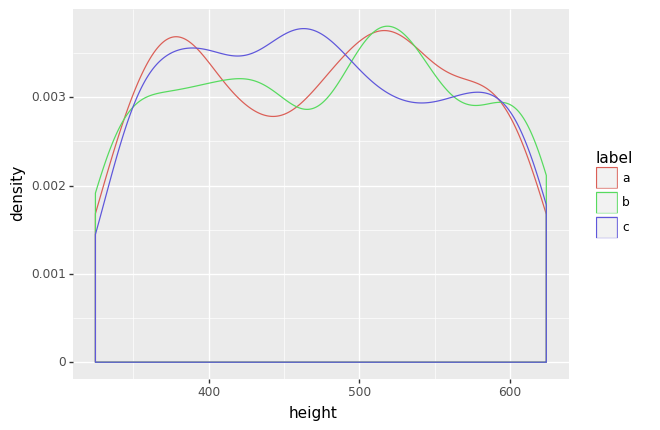

In [18]:
print(ggplot(train_df) + aes(x='height', color='label') + 
      geom_density())

- *The size of the image seems uninformative to tell apart the class labels.*

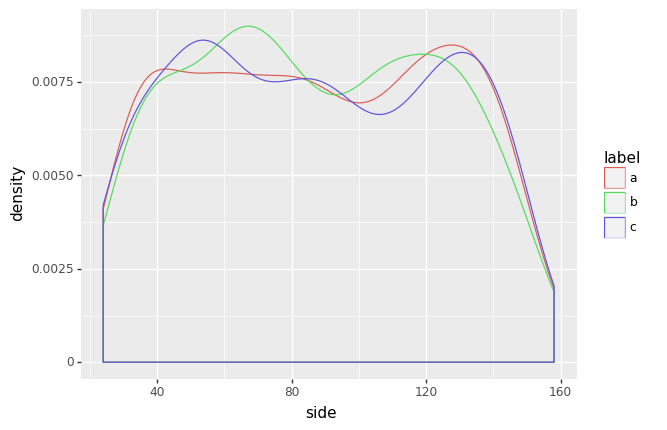

In [19]:
print(ggplot(train_df) + aes(x='side', color='label') + 
      geom_density())

- *The size of the colored patch seems also uninformative to tell apart the class labels.*

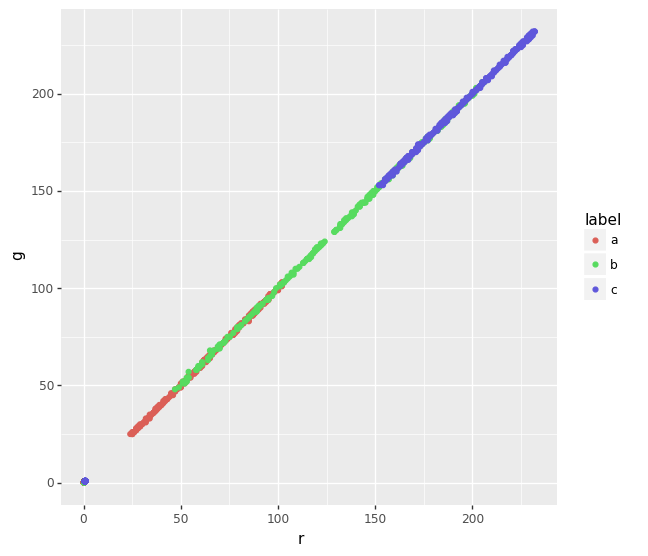

In [20]:
print(ggplot(train_df) + aes(x='r', y='g', color='label') + 
      geom_point() + coord_equal())

- *Color channel `r` seems identical to color channel `g`.* We saw this earlier from the statistics; now we can see it for each image. 

- *The color channels `r` and `g` seem somewhat informative to tell apart the class labels.*

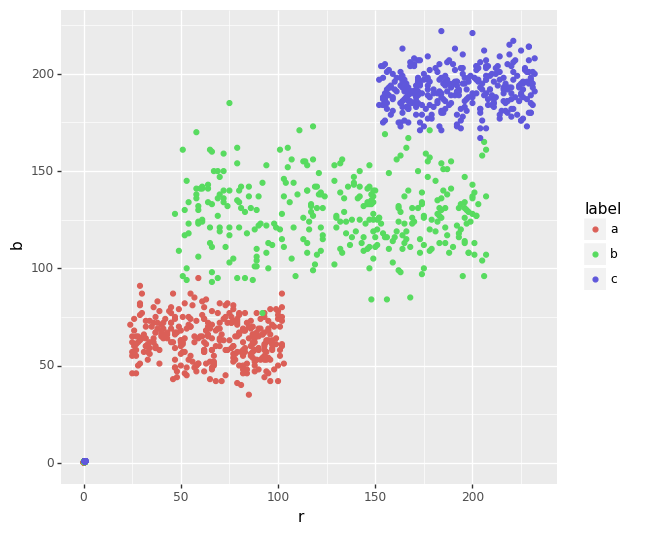

In [21]:
print(ggplot(train_df) + aes(x='r', y='b', color='label') + 
      geom_point() + coord_equal())

#### Insight
- *The color channels `b` seems very informative to tell apart the class labels.*
- Low `b`lue channel: class `a`
- Mid `b`lue channel: class `b`
- High `b`lue channel: class `c`

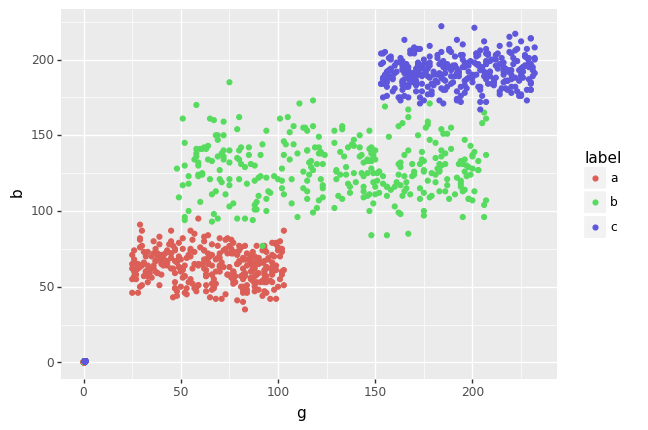

In [22]:
print(ggplot(train_df) + aes(x='g', y='b', color='label') + 
 geom_point())

Same as before. Not surprising, since `b = g`.

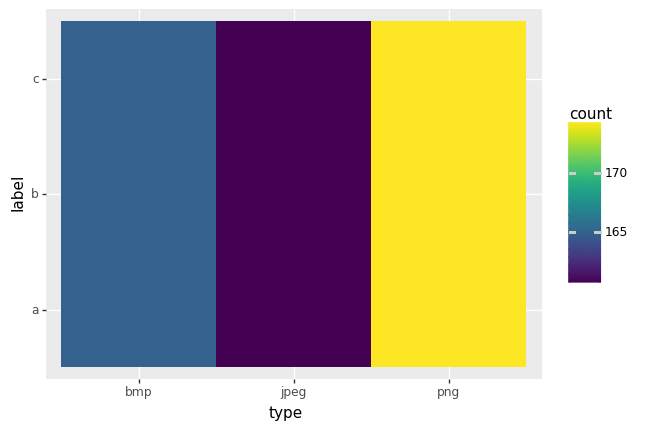

In [23]:
print(ggplot(train_df) + aes(x='type', y='label') + 
      geom_bin2d())

Class label is uniformly distributed for file type. $\iff$  
File type is totally uninformative. $\iff$  
Knowing the file type doesn't tell us anything about the label.

Also, this *must* be a toy data set, without doubt. And its generative model in psudocode:

```
for filetype in ['bmp', 'jpeg', 'png']:
    for class in [0, 1, 2]:
        generate samples
        saves images
```

### Colors seem to tell a lot. Let's use a better visualization for them.

In [24]:
def plot_3d_interactive(df = train_df):
    """
    Plot interactive 3D scatter plot over the RGB space, and show metadata.
    """
    import plotly as py
    import plotly.graph_objs as go

    label2color = {
        'a': 'red',
        'b': 'green',
        'c': 'blue'
    }

    trace = go.Scatter3d(
        x=df['r'],
        y=df['g'],
        z=df['b'],

        mode='markers',
        marker=dict(
            size=3,
            color=df['label'].map(label2color)
        ),
        name= '3d',

        # list comprehension to add text on hover
        text= [f"type: {itype}<br>side: {iside}<br>width: {iwidth}" 
               for itype,iside,iwidth 
               in list(zip(df['type'], 
                           df['side'], 
                           df['width']))],
        # suppress hover
        hoverinfo='text'
    )

 
    layout = dict(title = 'Classes in RGB space',
                  scene=dict(
                      xaxis={'title': 'r'},
                 yaxis={'title': 'g'},
                 zaxis={'title': 'b'}
                 )
                  )
                 

    data = [trace]
    fig = dict(data=data, layout=layout)

    py.offline.iplot(fig, filename = '3D.html')
    

plot_3d_interactive(train_df)

### Detour 2: extreme values - what are they?

What's up with the dot at the corner around `(0, 0, 0)`? 
- A bunch of zero values? 
- Empty images? 

Let's ignore or just exclude them. Should we?

In [25]:
# png format stores RGB in [0,1] while others store in 0..255
extremes = (train_df.r < 1) & (train_df.g < 1) & (train_df.b < 1)
train_df[extremes]

name label type  side  height  width         r  \
0     ./squares/train/a/412.png     a  png   112     343    343  0.133333   
1     ./squares/train/a/374.png     a  png   146     504    504  0.325490   
3     ./squares/train/a/162.png     a  png    44     384    384  0.286275   
8     ./squares/train/a/214.png     a  png   108     386    386  0.274510   
10    ./squares/train/a/201.png     a  png   118     401    401  0.360784   
...                         ...   ...  ...   ...     ...    ...       ...   
1489   ./squares/train/c/52.png     c  png   132     353    353  0.858824   
1492   ./squares/train/c/85.png     c  png    68     392    392  0.607843   
1495  ./squares/train/c/386.png     c  png    54     356    356  0.792157   
1498  ./squares/train/c/351.png     c  png    82     346    346  0.756863   
1499  ./squares/train/c/437.png     c  png   134     459    459  0.737255   

             g         b  n_colors  
0     0.133333  0.227451         1  
1     0.325490  0.250980         1  
3     0.286275  0.317647         1  
8     0.274510  0.235294         1  
10    0.360784  0.219608         1  
...        ...       ...       ...  
1489  0.858824  0.670588         1  
1492  0.607843  0.768627         1  
1495  0.792157  0.701961         1  
1498  0.756863  0.803922         1  
1499  0.737255  0.717647         1  

[522 rows x 10 columns]

#### Insight

The *extreme* values are all coming from `.png` files; that cannot be a coincicdence. In fact, none of the "non-extreme" values are `.png` either.

Actually, `.png` format stores RGB in $[0, 1]$ as floating point numbers while others store as unsight 8 bit integers, in $\{0, 1, ..., 255\}$.

Let's scale it.

In [26]:
# let's bring all the color space within [0,1]
def scale_colorspace(df):
    """
    scale into RGB represented in [0, 1]
    """
    # While floats [0, 1] takes more CPU to compute,
    # model coefficients will be easier to interpret
    df_scaled = df.copy()

    rows_to_scale = (df.r >= 1) & (df.g >= 1) & (df.b >= 1)
    df_scaled.loc[rows_to_scale, ('r', 'g', 'b')] = df.loc[rows_to_scale, ('r', 'g', 'b')]/255
    
    # do it during pre-processing to avoid over-computation
    df_scaled['labeln'] = df_scaled['label'].map({'a': 0, 'b': 1, 'c': 2})
    
    return df_scaled


train_scaled = scale_colorspace(train_df)
test_scaled = scale_colorspace(test_df)

In [27]:
# now let's replot the scatter plot
plot_3d_interactive(train_scaled)

train_scaled

name label  type  side  height  width         r  \
0     ./squares/train/a/412.png     a   png   112     343    343  0.133333   
1     ./squares/train/a/374.png     a   png   146     504    504  0.325490   
2      ./squares/train/a/88.jpg     a  jpeg    34     576    576  0.333333   
3     ./squares/train/a/162.png     a   png    44     384    384  0.286275   
4     ./squares/train/a/286.bmp     a   bmp    38     556    556  0.160784   
...                         ...   ...   ...   ...     ...    ...       ...   
1495  ./squares/train/c/386.png     c   png    54     356    356  0.792157   
1496  ./squares/train/c/147.jpg     c  jpeg    46     484    484  0.639216   
1497    ./squares/train/c/0.jpg     c  jpeg   113     591    591  0.717647   
1498  ./squares/train/c/351.png     c   png    82     346    346  0.756863   
1499  ./squares/train/c/437.png     c   png   134     459    459  0.737255   

             g         b  n_colors  labeln  
0     0.133333  0.227451         1       0  
1     0.325490  0.250980         1       0  
2     0.325490  0.137255         1       0  
3     0.286275  0.317647         1       0  
4     0.160784  0.250980         1       0  
...        ...       ...       ...     ...  
1495  0.792157  0.701961         1       2  
1496  0.639216  0.678431         1       2  
1497  0.717647  0.678431         1       2  
1498  0.756863  0.803922         1       2  
1499  0.737255  0.717647         1       2  

[1500 rows x 11 columns]

**Extreme values no more!**

<div style="text-align: right"> <h5> End of Detour 2 </h5> </div>

### Quantify observations

We saw blue channel was most informative, while the rest aren't much. But by how much? How can we quantify it?

We can use mutual information between two discrete processes `X` and `Y`. If knowing `X` tells us a lot about what `Y` is, then their mutual information will be high. 

Note: Mutual information is a generalization of statistical correlation, between arbitrary processes.
- Paerson correlation assumes linearity;
- Spearman correlation assumes monotonocity. 

We assume neither. 

Using my own library for discrete state sapce information theoretic analysis:
https://github.com/hyiltiz/info

In [28]:
# blue value seems mostly informative
# by how much?

# Import my information theory module
# https://github.com/hyiltiz/info
# Here including the relevant sections lines of the code for completeness

def compute_mutual_information(X, Y, domain):
    observed = list(zip(X, Y))
    N = len(observed)

    domain = ((0, 255), (0, len(classes)))

    # NOTE: range() upper range is larger by 1
    grid = itertools.product(range(domain[0][0], domain[0][1]),
                   range(domain[1][0], domain[1][1]))

    # compute the joint frequency table
    observed_counts = [observed.count(coord) for coord in grid]

    cXY = np.array(observed_counts).reshape(domain[0][1], domain[1][1])

    # compute the marginal counts
    [cX, cY] = np.meshgrid(cXY.sum(axis=0), cXY.sum(axis=1))

    # now normalize into probability mass functions
    [pXY, pX, pY] = [cXY/N, cX/N, cY/N]
    pXpY = pX * pY

    # get rid of the zero events (only in the joint is sufficient)
    # 0 * log(0/[possibly zero]) := 0 for information
    # this limit actually comes from the expectation definition of information
    nonzeros = pXY != 0
    nonzeros_X = pX[0, :] != 0
    nonzeros_Y = pY[:, 0] != 0

    # -inf < pmi < min(-log(pX), -log(pY))
    pointwise_mutual_information = np.log2(pXY[nonzeros]/pXpY[nonzeros])

    # the expected value of the pointwise MI
    mutual_XY = sum(pXY[nonzeros] * pointwise_mutual_information)

    # now compute other relevant information metrics
    # the self-information
    self_information_X = -np.log2(pX[0, :])

    # entropy := expected self information
    HX = sum(pX[0, :][nonzeros_X] * self_information_X[nonzeros_X])


    # print(f"====\nmutual_XY:{mutual_XY}, "
    #       f"normalied by entropy(X): {mutual_XY/HX}\n, "
    #       f"{out['mutual-information']}")
    # import ipdb; ipdb.set_trace() # BREAKPOIN for debugging

    return (mutual_XY, mutual_XY/HX)

In [29]:
def analyze_mi(data = train_scaled):
    """Perform information theoretic analysis between target class labels
and predictors. Computae mutual information between class labels (discrete)
and discrete predictors (or binned), using custom implemented function.
Mutual information can be viewed as a generalized measure of correlation,
between arbitrary processes, whereas paerson correlation assumes linearity,
and spearman correlation assumes monotonocity. Normalized mutual information 
tells us how much percentage of the information required for calssification
is contained in the predictor. For example, if we have 3 classes, we need
log2(3) bits of information from a sample to correctly classify; normalization 
simplify scales mutual by this factor.
    """
    
    # the algorithm is more robust for discrete samples
    train255 = train_scaled.copy()
    train255.loc[:, ('r', 'g', 'b')] = train255.loc[:, ('r', 'g', 'b')]*255

    train255 = train255.astype({
        'r': 'int',
        'g': 'int',
        'b': 'int',
        'height': 'int'
    })
    train255['labeln'] = train255['label'].map(ord) - 97

    train255['typen'] = train255['type'].map({
        'png': 0,
        'jpeg': 1,
        'bmp': 2})

    domain_color = ((0, 255), (0, 2))
    
    # first prepare all the input predictors as a list
    # then submit for computation
    # the computation itself can be parallel and distributed
    kwargs = [
        (train255.r, train255.labeln, domain_color),
        (train255.g, train255.labeln, domain_color),
        (train255.b, train255.labeln, domain_color),
        (train255.side, train255.labeln, ((0,train255.side.max()), (0,2))),
        (train255.typen, train255.labeln, ((0,train255.typen.max()), (0,2)))
    ]

    rows = ['red', 'green', 'blue', 'side', 'filetype']
    columns = ['mutual info (bits)', 'normalized (%)'] # of log2(3) where 3 is #class
    mi_tbl = list(map(lambda x: compute_mutual_information(*x), kwargs))

    mi_df = pd.DataFrame(mi_tbl, columns = columns)
    mi_df['predictor'] = rows
    
    return(mi_df)


# information theoretic analysis for the train set
mi_df = analyze_mi(train_scaled)
display(mi_df)

# first reshape it into the long format
mi_long = mi_df.melt('predictor')
mi_long.rename(columns = {'value': 'information', 'variable': 'measure'}, inplace=True)

# rearrange the order
rows = ['red', 'green', 'blue', 'side', 'filetype']
mi_long['predictor'] = mi_long['predictor']\
    .astype(pd.CategoricalDtype(ordered=True))\
    .cat.reorder_categories(rows, 
                           ordered=True)

mutual info (bits)  normalized (%) predictor
0        1.025581e+00    6.470695e-01       red
1        1.021759e+00    6.446583e-01     green
2        1.543974e+00    9.741389e-01      blue
3        1.376322e-01    8.683626e-02      side
4        1.114792e-16    7.033557e-17  filetype

- Normalized mutual information tells us how much percentage of the information required for calssification is contained in the predictor.

- For example, we have 3 classes. So we need `log2(3)` bits of information (from a sample to correctly classify it). Normalization simplify scales mutual by this factor. Therefore, it is a percentage.

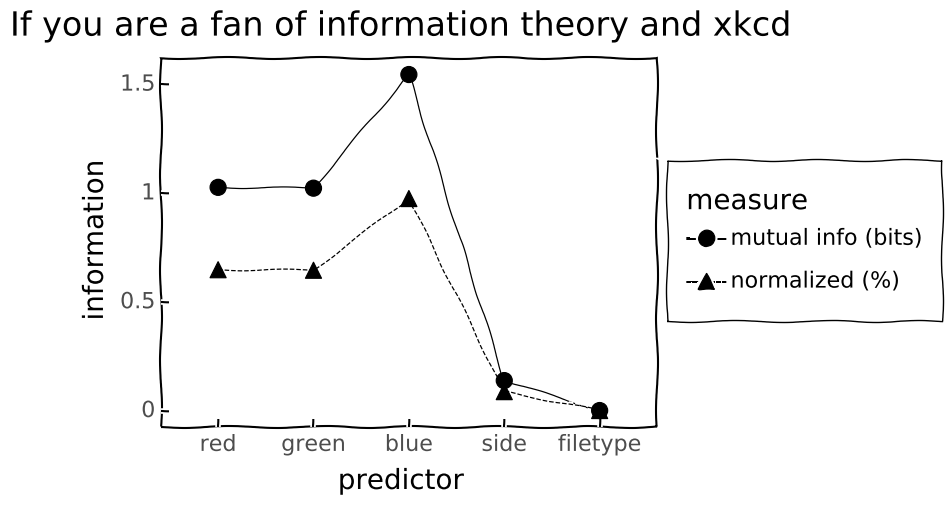

In [49]:
print(ggplot(mi_long) + 
 aes(x='predictor', y='information', shape='measure', linetype='measure', group='measure') + 
 geom_line() + geom_point(size=6) +
 theme_xkcd(base_size=20) +
 ggtitle('If you are a fan of information theory and xkcd')
)

### Insight quantified

- blue channel contains `97.4%` of the information required for classification; **almost perfectly informative**;
- The size of the colored patch is only `8.7%` informative; almost useless.
- File type contains `0%` information; totally useless.

## Quick summary

- Data description  
We have a set of simple images and a few classes. The images are split into training set (around 1500 images, 500 images per class) and a test set (1500 images, 500 images per class). The images are of several different common image binary storate formats.

- Problem description  
We need to design, implement, train and validate a classification model. 

- Confirmed observations  
1. All the images contain a single colored patch
2. The margins are indeed uniformly white
3. Each of the color patches are uniform (contains only a single color)
4. The squares have different sizes, but is irrelevant to the class labels.
5. *Blue channel is almost enough by itself for classification.*

## Propose a set of models

We could fire at the problem with big cannons from supervised machine learning such as:
 - linear multiclass classifier
 - SVM
 - Fisher's discriminant
 - CNN
 - multiclass logistic regression
 - decision trees
 - nnets
 
Or even unsupervised such as kmeans.
 
But we've seen that:
- channel `r` is identical to channel `g`
- channel `b` contains almost all the information

*So we can do without any of them; just do a geometric projection and threshold it.*

### Geometric projection model (our custom model)

- **Our custom algorithm**: The sample points are forming a plane in RGB space. Let's first **rotate** the plane s.t. they lie flat on the "wall" (x-y plane). Once it is flat on the wall, just draw two horizontal lines *appropriately* (hint: optimization), then use these lines as thresholds for classification.

We can flatten the 3D dot cloud by rotating along channel `b` by 45 degrees (because `b=g` describes a 45 degree line on b-g axes). Rotation is a linear transformation, which can be represented as a matrix multiplication...

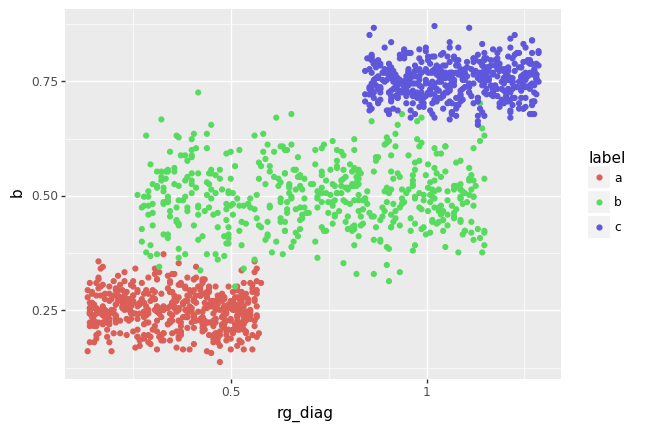

In [32]:
# Further decrease dimensions by project into 2D by rotation.
angle = np.pi/4
rg_diag_unit = [1/np.cos(angle), 0, 0]

# matrix product as a linear projection
train_scaled['rg_diag'] = train_scaled.loc[:, ('r', 'g', 'b')] @ rg_diag_unit

print(ggplot(train_scaled) + 
      aes(x='rg_diag', y='b', color='label') + 
      geom_point() 
     )

We further decreased the dimensions to only `2`. Now the classifier seems obvious: just draw two horizontal lines (and use them as thresholds/boundaries for classification).

We can eyeball a guess from the plot.

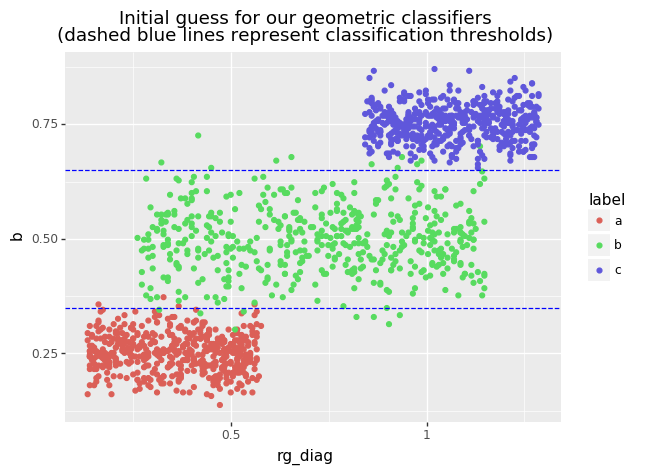

In [33]:
thresholds_guess = [0.35, 0.65]

print(ggplot(train_scaled) + 
      aes(x='rg_diag', y='b', color='label') + 
      geom_point() +
      geom_hline(yintercept=thresholds_guess[0], linetype='dashed', color='blue') +
      geom_hline(yintercept=thresholds_guess[1], linetype='dashed', color='blue') +
      ggtitle('Initial guess for our geometric classifiers\n(dashed blue lines represent classification thresholds)')
     )

In [35]:
# try a guess
thresholds_init = [0.35, 0.65]


def blue_channel_classifier(data = train_scaled, thresholds = [0.35, 0.65]):
    """
    Classification based on the blue channel. Compute error given two thresholds.

    """
    
    # initialize to label b
    class_pred = np.ones(data.b.shape)
    
    # vectorized evaluation
    class_pred[data.b < thresholds[0]] = 0 # class a
    class_pred[data.b >= thresholds[1]] = 2 # class c
    

    # not RMSE, just classification error, as percentage
    error = np.mean(data.labeln != class_pred) 
    return (class_pred, error)


blue_channel_classifier(data = train_scaled, thresholds = thresholds_init)[1]

0.016

`1.6%` of error for an informed guess, not bad! But how can we do better? Optimization. Specifically, we can systematically vary where to place the two thresholds using optimization; the best two horizontal lines should lead to the smallest classification error. 

Thus, we *define* our cost function as this classification error, given two thresholds.


### Optimize threshold placement
The model is an optimization for the best two horizontal lines that minimizes misclassification error from the *training* data set.

In [38]:
def model_projection(train, test):
    """
    Fit geometric model via optimization and report model performance.
    """

    cost_f = lambda x: blue_channel_classifier(train_scaled, x)[1]
    thresholds_init = [0.35, 0.65]
    res = optimize.minimize(cost_f, 
               thresholds_init, 
               method='nelder-mead',
               options={'disp': False}, 
               bounds=optimize.Bounds([0,1], [0,1])
                           )

    print('After optimization, minimzied training error to:', res.fun) 
    # with optimization, we reached 1.47% by only using two parameters
    # to classify the original 1500 images
    # that contained 1048703688 ~ 1 billion data points
    # with just two interpretable parameters!


    test_pred, generalization_error = blue_channel_classifier(data = test_scaled, thresholds = res.x)
    print('Generalization error computed from trained model on the test set is: ', generalization_error)

    domain_label = ((0,2), (0,2))
    mi, mi_scaled = compute_mutual_information(test_pred, test_scaled.labeln, domain_label)

    return({
        'model': 'projection-optimization',
        'learning-error': res.fun,
        'generalization-error': generalization_error,
        'mutual-information': mi,
        'mutual-information-normalized': mi_scaled,
        'degree-of-freedom': len(res.x)
    }, res)


ireport, res = model_projection(train_scaled, test_scaled)

After optimization, minimzied training error to: 0.014666666666666666
Generalization error computed from trained model on the test set is:  0.021333333333333333


In [39]:
report = []
report.append(ireport)

ireport

{'model': 'projection-optimization',
 'learning-error': 0.014666666666666666,
 'generalization-error': 0.021333333333333333,
 'mutual-information': 1.4390780396443617,
 'mutual-information-normalized': 0.9079571529229132,
 'degree-of-freedom': 2}

### Detour 3: How good was our optimization?

The optimization space plots training error as a function of the model parameters (the heights of the two horizontal cutoff lines). We see that:

- Our initial guess was indeed quite close to the best
- There are some regions with lots of local minima
- Need to be careful to avoid getting stuck in lucal minima (clear to see from 3D plot)

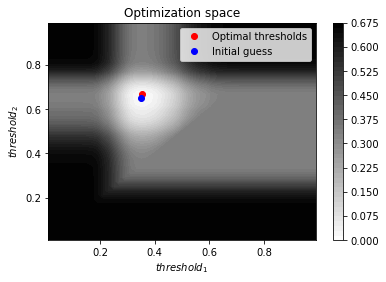

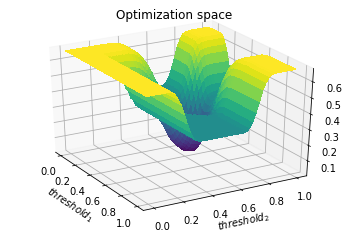

In [40]:
def plot_projection_optimization(thresholds_init, 
                                 train_scaled, 
                                 res):
    """Plot the cost function over the parameters to be optimized"""
    
    # Make a grid to evaluate the function (for plotting)
    xg, yg = np.meshgrid(np.linspace(0, 1), np.linspace(0, 1))

    # turn it into ternary function to vectorize over matrices
    cost_f = lambda x: blue_channel_classifier(train_scaled, x)[1]
    cost_fv = np.vectorize(lambda x, y: cost_f([x, y]))
    cost_surface = cost_fv(xg, yg)

    plt.figure()
    plt.contourf(cost_surface, extent=[0, 1, 0, 1], origin="lower", cmap='gray_r', levels=50)
    plt.plot(res.x[0], res.x[1], 'ro')
    plt.plot(thresholds_init[0], thresholds_init[1], 'bo')
    plt.title('Optimization space')
    plt.xlabel('$threshold_1$')
    plt.ylabel('$threshold_2$')
    plt.legend(['Optimal thresholds', 'Initial guess'])
    plt.colorbar()
    
    # how easily could we get stuck in a local minimum?
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(xg, yg, cost_surface, rstride=1, cstride=1,
                           cmap='viridis', linewidth=0, antialiased=False)

    ax.set_xlabel('$threshold_1$')
    ax.set_ylabel('$threshold_2$')
    ax.set_zlabel('Train error')
    ax.set_title('Optimization space')
    ax.azim = -30
    ax.elev = 30
    ax.dist = 10


plot_projection_optimization(thresholds_init = [0.35, 0.65], 
                                 train_scaled=train_scaled, 
                                 res=res)

<div style="text-align: right"> <h5> End of Detour 3 </h5> </div>

### Model summary
- Optimization had a training error of `1.4%`, and `2.1%` generalization error (for unseen/new data set, computed using the test set). 
- Our predictions were `90.8%` informative to classify an unseen sample.

## Standard models

Our custom built model had satisfactory performance. How does it compare to standard models for multi-class supervised learning? Let's try:

- Linear discriminant analysis
- Support vector machines (SVM)

In [41]:
# let's try a better classifier with a non-linear kernel to make use 
# of the rg_diag and the side of the color patch

def prep_inputs(train, test):
    """
    Prepare the inputs for a more general training.
    """
    predictors = ['rg_diag', 'b', 'side']
    angle = np.pi/4
    rg_diag_unit = [1/np.cos(angle), 0, 0]

    train_scaled['rg_diag'] = train_scaled.loc[:, ('r', 'g', 'b')] @ rg_diag_unit
    X = train.loc[:, predictors]
    y = train.labeln

    # prepare the test input
    test_scaled['rg_diag'] = test_scaled.loc[:, ('r', 'g', 'b')] @ rg_diag_unit
    X_test = test.loc[:, predictors]
    y_test = test.labeln
    
    return (
        (X,y), # train set
        (X_test, y_test) # test set
    )


(X, y), (X_test, y_test) = prep_inputs(train_scaled, test_scaled)


def model_svd(data, n_components, model_name='LDA'):
    """Classify after doing a svd. Model name can be a LDA or PCA model.
    """
    model_map = {
        'LDA': (LDA, lambda m: m.coef_.size),
        'PCA': (PCA, lambda x: 0)
    }
    model_f, df = model_map[model_name]
    
    # data
    (X, y), (X_test, y_test) = data
    
    
    model = model_f(n_components=n_components)
    if model_name == 'PCA':
        X_r = model.fit(X).transform(X)
    else:
        X_r = model.fit(X, y).transform(X)
        
#     print(X_r.shape)
        
    
    # model performance profile
    try:
        test_pred = model.predict(X_test)
        train_pred = model.predict(X)
    except AttributeError as e:
        test_pred = np.zeros(y_test.shape) + np.NaN
        train_pred = np.zeros(y.shape) + np.NaN
            
    domain_label = ((0,2), (0,2))
    
    train_error = 1 - np.mean(train_pred == y)
    generalization_error = 1 - np.mean(test_pred == y_test)
    try:
        (mi, mi_scaled) = compute_mutual_information(test_pred, 
                                                 y_test, 
                                                 domain_label
                                                )
    except ZeroDivisionError as e:
        (mi, mi_scaled) = (np.nan, np.nan)
    
    ireport = {
        'model': f'{model_name}{n_components}',
        'learning-error': res.fun,
        'generalization-error': generalization_error,
        'mutual-information': mi,
        'mutual-information-normalized': mi_scaled,
        'degree-of-freedom': df(model)
    }
    
    
    # plot the model's first two components
    plt.figure()
    colors = ["red", "green", "blue"]
    lw = 2

    # if there is only one component
    # put 0s into the 2nd component for visualization
    if n_components == 1:
        X_r = np.concatenate([X_r, X_r], axis=1)
        X_r[:,1] = 0
        
    classes = y.unique()
    for color, i, target_name in zip(colors, [0, 1, 2], classes):
        plt.scatter(X_r[y == i, 0], X_r[y == i, 1], 
                    color=color, alpha=0.8, lw=lw, label=target_name)
    plt.legend(loc="upper right", shadow=False, scatterpoints=1)
    plt.title(model_name)

    return(ireport, model)

### Detour 4: How well was our dimensionality reduction? 

Let's compare against PCA.

<ipython-input-28-cd092b10f929>:45: RuntimeWarning:

divide by zero encountered in log2



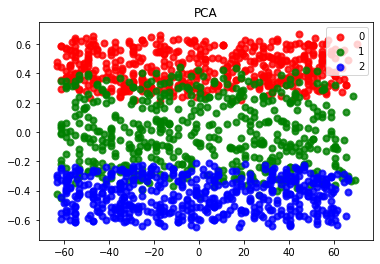

In [42]:
ireport, m = model_svd(((X, y), (X_test, y_test)) , 2, 'PCA')
report.append(ireport)

- PCA squished the axis such that all data fit into a square, minimizing variance.
- However, classes merged into each other, making it much harder to classify.

We must be careful what PCA minimizes and how!

<div style="text-align: right"> <h5> End of Detour 4 </h5> </div>

## Linear discriminant classifier

Let's try extracting 2 and 1 components.

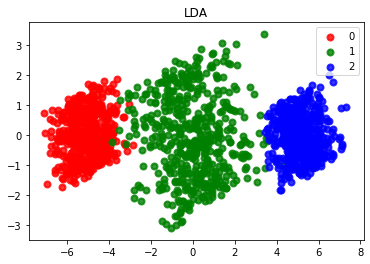

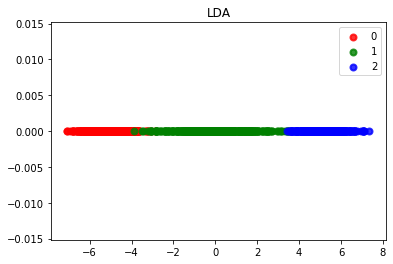

In [43]:
ireport, m = model_svd(((X, y), (X_test, y_test)) , 2, 'LDA')
report.append(ireport)


ireport, m = model_svd(((X, y), (X_test, y_test)) , 1, 'LDA')
report.append(ireport)

Linear discriminant tries to maximize the class difference. 

- Classes are much better separated compared to PCA
- Classification surfaces are harder to interpret compared to our threshold along `b` channel.
- LDA after projecting along 1 dimension simply squishes along the `y` dimension of the LDA with 2 dimensions. Not the same as just taking `b`.

## Support vector machines (with kernels)

Let's try a few commonly used kernels for models of varying complexity.

In [44]:
def classify_svm(train, test, kernel: str, degree: int):
    """Fit a support vector machine with the specified kernel, and return
    train and generalization error.
    """
    

    
    svm = make_pipeline(StandardScaler(), SVC(
        gamma='auto', # only useful for the rbf kernel
        kernel=kernel,
        degree=degree, # only useful for the poly kernel
        cache_size=500,
        probability=True
    ))
    
    svm.fit(X, y)
    train_error = 1 - svm.score(X, y)
    generalization_error = 1 - svm.score(X_test, y_test)
    
    (mi, mi_scaled) = compute_mutual_information(svm.predict(X_test), 
                                                 y_test, 
                                                 ((0,2), (0,2))
                                                )
    df = svm['svc'].n_support_.sum()
    
    # give the model a descriptive name
    if kernel == 'poly':
        name = f'{kernel}{degree}'
    else:
        name = f'{kernel}'
        
    ireport = {
        'model': f'svm-{name}',
        'learning-error': train_error,
        'generalization-error': generalization_error,
        'mutual-information': mi,
        'mutual-information-normalized': mi_scaled,
        'degree-of-freedom': df
    }
    
    
    return(ireport, svm)


for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    if kernel == 'poly':
        for degree in [1, 2, 3]:
            [ireport,svm] = classify_svm(train_scaled, test_scaled, 
                                         kernel, degree)
            report.append(ireport)
    else:
        # the degree is meaningless for non-polynomial kernels
        [ireport,svm] = classify_svm(train_scaled, test_scaled, 
                                         kernel, 0)
        report.append(ireport)


### Evaluate models by comparing various performance metrics

We have our custom model, LDA and SVM. Let's compare their errors and information metrics.

In [45]:
# report = report[0:4]
report_df = pd.DataFrame(report)
report_df.sort_values(by=['generalization-error', 'mutual-information-normalized'], inplace=True)
report_df['best'] = 3
report_df.loc[report_df['model']=='svm-poly1', 'best'] = 1
report_df.loc[report_df['model']=='projection-optimization', 'best'] = 2
report_df.loc[report_df['model']=='PCA2', 'generalization-error'] = np.nan
report_df['best'] = report_df['best'].astype('category')

display(report_df)

model  learning-error  generalization-error  \
5                svm-poly1        0.013333              0.016000   
4               svm-linear        0.011333              0.016667   
8                  svm-rbf        0.012667              0.016667   
7                svm-poly3        0.010667              0.019333   
0  projection-optimization        0.014667              0.021333   
2                     LDA2        0.014667              0.026667   
3                     LDA1        0.014667              0.026667   
9              svm-sigmoid        0.123333              0.122000   
6                svm-poly2        0.342000              0.346000   
1                     PCA2        0.014667                   NaN   

   mutual-information  mutual-information-normalized  degree-of-freedom best  
5            1.470194                       0.927589                147    1  
4            1.465186                       0.924430                100    3  
8            1.466244                       0.925097                159    3  
7            1.441803                       0.909676                174    3  
0            1.439078                       0.907957                  2    2  
2            1.422313                       0.897380                  9    3  
3            1.422313                       0.897380                  9    3  
9            1.003982                       0.633442                268    3  
6            0.798722                       0.503937               1037    3  
1                 NaN                            NaN                  0    3

Best model `svm-poly1` is a support vector machine with polynomial kernels with 1 degree (linear with a constant). But how does it work?


### SVM explanation

SVM will first expand the predictor vectors using a kernel. For example, the best model `svm-poly1` will first *apply* a `poly1` kernel (it is just the formula `poly1:` $x \to ax + b$), meaning each predictor $x$ expands into two other predictors $ax$ and $b$ by the formula, essentially scaling the predictor by some factor then shifting it by some amount. $a$ and $b$ are some of the free parameters of the SVM. In addition to tweaking these free parameters to find the best classifier, SVM also chooses *some* data points (after the kernel transform) near the classification boundary as the *support vectors*, which will be used for making a classification decision.


### How good was our geometric projection model?
Compared to the best model `svm-poly1`, our model `projection-optimization`
- used only 2 free parameters, both interpretable
- 2% worse in normalized mutual information
- 1% worse in generalization error
- used 145 less free parameters

Our model was much less complex, much more interpretable, and tailed for this specific problem. 


### Other insights from model comparison
`svm-poly3` was a more complex model, with a non-linear kernel and more free parameters. Although `svm-poly3` had less error during learning, but it has poor generalization error (when it comes to classifying unseen dataset). This is an sign of **overfitting**!


### Visualizing model comparison table

/home/hyiltiz/.local/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning:

geom_point : Removed 1 rows containing missing values.



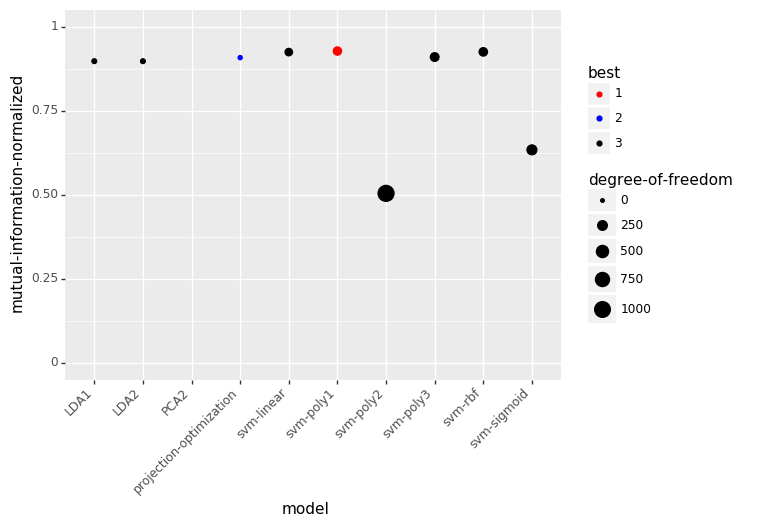

/home/hyiltiz/.local/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning:

geom_point : Removed 1 rows containing missing values.



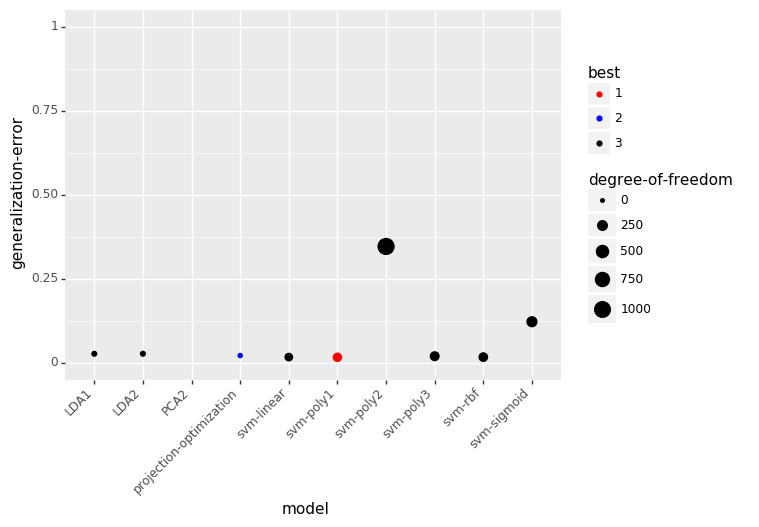

In [47]:
gg1 = (ggplot(report_df) + 
 aes(x='model', y='mutual-information-normalized', 
     size='degree-of-freedom',
     color='best'
    ) + 
 theme(axis_text_x = element_text(angle = 45, vjust = 1, hjust=1)) +
 scale_y_continuous(limits=[0,1]) +
 scale_color_manual(values=['red', 'blue', 'black']) +
 geom_point()
)


gg2 = (ggplot(report_df) + 
 aes(x='model', y='generalization-error', 
     size='degree-of-freedom',
     color='best'
    ) + 
 theme(axis_text_x = element_text(angle = 45, vjust = 1, hjust=1)) +
 scale_y_continuous(limits=[0,1]) +
 scale_color_manual(values=['red', 'blue', 'black']) +
 geom_point()
)

print(gg1)

print(gg2)

# Conclusion and future directions

## Problem complexity
The problem was vastly simplified by the initial dimensionality reduction from image pixel space into just the color of the central pixel. That is idealistic. In general, feature extraction may involve (deep) convolutional neural networks (CNN), unsupervized learning methods and designing custom kernels.


## On-line learning
Trainign model was performed on the full data set (batch learning). We could adopt an on-line learning classifier that can take one sample at a time. This will avoid re-training as more data accumulates over time, and is more convenient to provide as an API for others to use. 


## Probabilistic inference
Also, being able to put a confidence on our prediction, by means of a confidence interval or a point probability for our prediction would be highly valuable to make practical decisions; low confidence predictions should weight less for a business decision and we should rely more on high-confidence predictions. 

Most of the models above can be naturally extended to predict confidence for each of its predictions. Since it was not required for this case study, the topic is not explored at all.


## Causal inference
Simply being able to predict is less valuable for making informed decisions in practice as compared to having insights into the causal links that are implied by the data. Building causal models that enables us to make strong causal predictions will be valuable in practice.


## Computational complexity
While in general, more elaborate models lead to better prediction performance and better generalization, they also take more resources (time, storage, input data) to run. It is thus important to consider the computational time and space complexity of the algorithms for the given problem. It is also possible and important to consider optimizing the same algorithm, which is usually possible with more insight and mathematical derivations.

Migrating to an online-algorithm may help since only one sample is used for training at a time, but we would still need to be careful. In the case that the model architecture needs an adjustment for an on-line learning model, we would still need to learn using all the data all over again.


# Final note on development practices
I am using *functional style* in this demo. Specifically:
- most computations are abstracted into (pure) functions;
- IO actions are notably outside such pure functions;
- avoid custom objects and methods for simplicity and ease of communication and maintenance.

This allows:
- writing modular code to separate concerns;
- easy to run in distributed parallel environments;
- computation and algorithms are encapsulated into small easy-to-maintain functions;
- no namespace collision;
- can be easily integrated into an existing custom module.


I am open to restricting myself to any specific set of libraries, such as the standard libraries and those with commercial friendly licenses (like MIT, BSD etc.) or ones developed in-house, as favored by the team. I can quickly pick up new libraries and languages.

# Thank you!

Thank you for taking the time to read through this rather lengthy report. Let me know if you have any feedback, suggestions or if you spotted any mistakes, at <hormet.yiltiz@gmail.com>.